## Describe datasets and deliver basic stats

In [1]:
import pandas as pd 
import numpy as np 
from src.utils.preprocess import get_videoid

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

import yaml
with open("../../src/configs.yml", "r") as configs:
    configs = yaml.safe_load(configs)

ROOTPATH = configs["ROOTPATH"]
DATAPATH = configs["DATAPATH"]
DATAPATH2 = configs["DATAPATH2"]
ROOTPATH2 = configs["ROOTPATH2"]
OUTPATH = "../../output/results-summary-122724/"

START = configs["START"]
END = configs["END"]
print(configs)
print(START)
print(END)

{'ROOTPATH': '/Users/yijingch/Documents/GITHUB/invisible-public/', 'ROOTPATH2': '/Users/yijingch/Documents/GITHUB/dd-full/', 'DATAPATH': '/Users/yijingch/Documents/GITHUB/dd-full/data/', 'DATAPATH2': '/Users/yijingch/Documents/GITHUB/collect-youtube-content/data/', 'INDEXPATH': '/Users/yijingch/Documents/GITHUB/dd-full/index/', 'START': datetime.datetime(2018, 5, 1, 0, 0), 'END': datetime.datetime(2023, 5, 1, 0, 0)}
2018-05-01 00:00:00
2023-05-01 00:00:00


## Load view, subscribe, comment data

In [2]:
view_all = pd.read_csv(DATAPATH + "youtube/yt_watch.csv", sep=";")
view_all = view_all[["respondent_id","titleUrl","channel_url", "timestamp"]].rename(columns={"titleUrl":"video_url"})
view_all["channel_id"] = view_all["channel_url"].map(lambda x: x.split("/")[-1] if str(x)!= "nan" else np.NaN)
view_all["video_id"] = view_all["video_url"].map(lambda x: get_videoid(x))
view_all = view_all[["respondent_id","channel_id","video_id","timestamp"]]
# view_all = view_all.dropna(subset = ["respondent_id", "video_id", "channel_id"])[["respondent_id","channel_id","video_id","timestamp"]]

subscribe_all = pd.read_csv(DATAPATH + "youtube/yt_subscriptions.csv", sep=";")[["respondent_id","channel_id"]]

comment_all = pd.read_csv(DATAPATH + "youtube/yt_comments_from2018may_to2023may_new.csv", sep=";").rename(columns={"snippet.channelId":"channel_id"})
# comment_all = pd.read_csv(DATAPATH + "youtube/yt_comments_from2018may_to2023may_check.csv", sep=";").rename(columns={"snippet.channelId":"channel_id"})
comment_all = comment_all[["respondent_id","video_id", "channel_id"]]
comment_public = pd.read_pickle(DATAPATH + "youtube/yt_comments_public_061824.pkl")

## Align the time period [FROM May 2018 to April 2023]

In [3]:
view_all["timestamp"] = pd.to_datetime(view_all["timestamp"])
view_all = view_all[(view_all["timestamp"]>=START)&(view_all["timestamp"]<=END)].copy()

comment_public["timestamp"] = pd.to_datetime(comment_public["published_at"]).dt.tz_localize(None)
comment_public = comment_public[(comment_public["timestamp"]>=START)&(comment_public["timestamp"]<=END)].copy()
# subscribing data cannot be filtered; sample comment is already filtered

## Load survey data

In [4]:
pol_df = pd.read_csv(DATAPATH + "survey/pol_survey_cleaned_NEW_INCLUDEALL.csv").rename(columns={"user_id":"respondent_id"})
pol_df.head()
print(pol_df.columns)

Index(['respondent_id', 'weight', 'gender', 'birth_year', 'education',
       'fb_freq', 'ig_freq', 'tw_freq', 'yt_freq', 'lk_freq', 'tt_freq',
       'sp_freq', 'sns_view_politics', 'sns_view_politics_friends',
       'sns_view_politics_disagree', 'sns_view_politics_progov',
       'sns_view_politics_antigov', 'seek_politics_tv', 'seek_politics_radio',
       'seek_politics_newpp', 'seek_politics_sites', 'seek_politics_sns',
       'seek_politics_convo', 'talk_politics_frfa', 'align_politics_frfa',
       'interest_politics', 'vote_party_2022', 'would_go_vote_sunday',
       'would_vote_party_sunday', 'know_sppt_fdsz', 'know_sppt_mszp',
       'know_sppt_jbbk', 'know_sppt_lmp', 'know_sppt_dk', 'know_sppt_mtum',
       'know_sppt_mhzk', 'know_relate_fdsz', 'know_relate_mszp',
       'know_relate_jbbk', 'know_relate_lmp', 'know_relate_dk',
       'know_relate_mtum', 'know_relate_mhzk', 'feel_thm_fdsz',
       'feel_thm_mszp', 'feel_thm_jbbk', 'feel_thm_lmp', 'feel_thm_dk',
       'feel_

In [5]:
print("# of all respondents:", pol_df["respondent_id"].nunique())
users = set(view_all["respondent_id"].tolist()).union(set(subscribe_all["respondent_id"].tolist())).union(comment_all["respondent_id"].tolist())
print("# of respondents who have youtube activities:", len(users))

# of all respondents: 758
# of respondents who have youtube activities: 735


In [6]:
# load all political channel 
cols = ["channel_id", "upload_id", "topics_str"]
# channel_info = pd.read_csv(DATAPATH2 + "clean/channel-info.csv")[cols].dropna(subset="topics_str")
channel_info = pd.read_pickle(DATAPATH2 + "clean/channel-info-042624.pkl")[cols].dropna(subset="topics_str")

# get a list of political videos and channels that have uploaded political videos
pol_videos = pd.read_pickle(DATAPATH + "youtube/youtube_video_meta_politics.pkl")["video_id"].tolist()
pol_videos_ch = set(pd.read_pickle(DATAPATH + "youtube/youtube_video_meta_politics.pkl")["channel_id"].tolist())

CHANNEL_CATG = "Politics"
pol_channels = channel_info[channel_info["topics_str"].str.contains(CHANNEL_CATG)]["channel_id"].tolist()
pol_channels = set(pol_channels).union(pol_videos_ch)
print("# of political channels:", len(set(pol_channels)))  # 11346


# of political channels: 11346


In [7]:
view_pol = view_all[view_all["channel_id"].isin(pol_channels)]
subscribe_pol = subscribe_all[subscribe_all["channel_id"].isin(pol_channels)]
comment_pol = comment_all[comment_all["channel_id"].isin(pol_channels)]
comment_public_pol = comment_public[comment_public["channel_id"].isin(pol_channels)]

In [8]:
users2 = set(view_pol["respondent_id"].tolist()).union(set(subscribe_pol["respondent_id"].tolist())).union(comment_pol["respondent_id"].tolist())
print("# of respondents who have engaged with at least one political channel:", len(users2))

# of respondents who have engaged with at least one political channel: 700


## Load channel labels

In [9]:
channel_labels_all = pd.read_excel(ROOTPATH2 + "index/yt_polclass_20240627.xlsx")
channel_labels_all

label_col = "classification_lvl1_4cat"
LABEL_MAP = {
    1: 0, # neutral 
    2: -1, # anti-gov 
    3: 1, # pro-gov
}

channel_labels = channel_labels_all[channel_labels_all[label_col].isin(LABEL_MAP.keys())]

CHANNEL_LABEL_MAP = {}
for lab,val in LABEL_MAP.items():
    channel_subdf = channel_labels[channel_labels[label_col]==lab]
    these_channels = set(channel_subdf["channel_id"].tolist())
    print(lab, val, "# of channels", len(these_channels))
    for this_ch in these_channels:
        CHANNEL_LABEL_MAP[this_ch] = {}
        CHANNEL_LABEL_MAP[this_ch]["leaning"] = val 

CHANNEL_LABEL_MAP["UCKY8HrMpm32WAMK0lauLAZA"]["leaning"] = 1
len(CHANNEL_LABEL_MAP)

1 0 # of channels 149
2 -1 # of channels 276
3 1 # of channels 139


564

In [10]:
these_channels = CHANNEL_LABEL_MAP.keys()
view_pol2 = view_all[view_all["channel_id"].isin(these_channels)]
subscribe_pol2 = subscribe_all[subscribe_all["channel_id"].isin(these_channels)]
comment_pol2 = comment_all[comment_all["channel_id"].isin(these_channels)]
comment_public_pol2 = comment_public[comment_public["channel_id"].isin(these_channels)]

In [11]:
users3 = set(view_pol2["respondent_id"].tolist()).union(set(subscribe_pol2["respondent_id"].tolist())).union(comment_pol2["respondent_id"].tolist())
print("# of respondents who have engaged with at least one political channel:", len(users3))

# of respondents who have engaged with at least one political channel: 668


In [12]:
print("**** VIEWING ****")
print("# of unique users:", view_pol2["respondent_id"].nunique())
print("# of unique channels:", view_pol2["channel_id"].nunique())
print("# of unique videos:", view_pol2["video_id"].nunique())

print("**** SUBSCRIBING ****")
print("# of unique users:", subscribe_pol2["respondent_id"].nunique())
print("# of unique channels:", subscribe_pol2["channel_id"].nunique())

print("**** COMMENTING ****")
print("# of unique users:", comment_pol2["respondent_id"].nunique())
print("# of unique channels:", comment_pol2["channel_id"].nunique())
print("# of unique videos:", comment_pol2["video_id"].nunique())

**** VIEWING ****
# of unique users: 640
# of unique channels: 545
# of unique videos: 57400
**** SUBSCRIBING ****
# of unique users: 299
# of unique channels: 210
**** COMMENTING ****
# of unique users: 72
# of unique channels: 108
# of unique videos: 993


In [13]:
# distributions

view_aggr = view_all.groupby("respondent_id").agg({"video_id":lambda x:len(list(x))}).reset_index()
subscribe_aggr = subscribe_all.groupby("respondent_id").agg({"channel_id":lambda x:len(set(x))}).reset_index()
comment_aggr = comment_all.groupby("respondent_id").agg({"video_id":lambda x:len(set(x))}).reset_index()

In [14]:
view_aggr_pol = view_pol.groupby("respondent_id").agg({"video_id":lambda x:len(list(x))}).reset_index()
subscribe_aggr_pol = subscribe_pol.groupby("respondent_id").agg({"channel_id":lambda x:len(set(x))}).reset_index()
comment_aggr_pol = comment_pol.groupby("respondent_id").agg({"video_id":lambda x:len(set(x))}).reset_index()

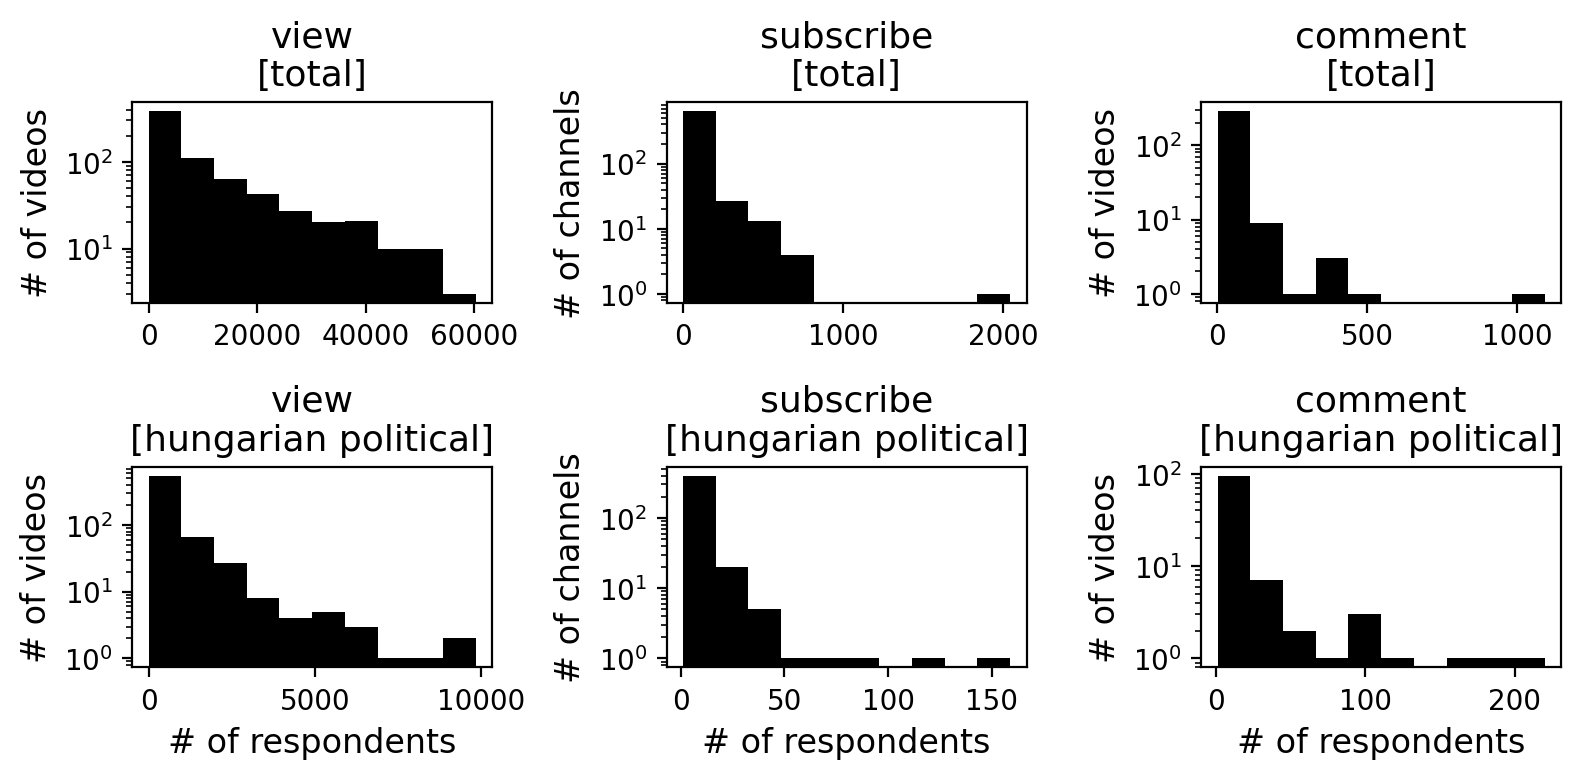

In [44]:
fig,ax = plt.subplots(figsize=(8,4), ncols=3, nrows=2)
ax[0,0].hist(view_aggr["video_id"], color="black")
ax[0,0].set_ylabel("# of videos", fontsize=12)
ax[0,1].hist(subscribe_aggr["channel_id"], color="black")
ax[0,1].set_ylabel("# of channels", fontsize=12)
ax[0,2].hist(comment_aggr["video_id"], color="black")
ax[0,2].set_ylabel("# of videos", fontsize=12)

ax[1,0].hist(view_aggr_pol["video_id"], color="black")
ax[1,0].set_ylabel("# of videos", fontsize=12)
ax[1,1].hist(subscribe_aggr_pol["channel_id"], color="black")
ax[1,1].set_ylabel("# of channels", fontsize=12)
ax[1,2].hist(comment_aggr_pol["video_id"], color="black")
ax[1,2].set_ylabel("# of videos", fontsize=12)

labels = ["view", "subscribe", "comment"]
for i in range(3):
    ax[0,i].set_yscale("log")
    ax[1,i].set_yscale("log")
    ax[1,i].set_xlabel("# of respondents", fontsize=12)
    ax[0,i].set_title(f"{labels[i]}\n[total]", fontsize=13)
    ax[1,i].set_title(f"{labels[i]}\n[hungarian political]", fontsize=13)
plt.tight_layout()
plt.show()